# Machine Learning Foundation

## Section 2, Part c: Cross Validation 

## Learning objectives

By the end of this lesson, you will be able to:

* Chain multiple data processing steps together using `Pipeline`
* Use the `KFolds` object to split data into multiple folds.
* Perform cross validation using SciKit Learn with `cross_val_predict` and `GridSearchCV`


In [1]:
import numpy as np # For math
import pickle # For data reading
import pandas as pd # For df
import matplotlib.pyplot as plt # For plotting

from sklearn.preprocessing import StandardScaler, PolynomialFeatures # for transformation
from sklearn.model_selection import KFold, cross_val_predict # to avoid over-fitting
from sklearn.linear_model import LinearRegression, Lasso, Ridge # for reg
from sklearn.metrics import r2_score, mean_squared_error # for evaluation
from sklearn.pipeline import Pipeline # for automation

In [2]:
# Note we are loading a slightly different ("cleaned") pickle file
boston = pickle.load(open('/Users/salahkaf/Desktop/IBM/boston_housing_clean.pickle', "rb" ))

In [3]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [4]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [5]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
print(boston_description)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

**Your response below**

1- We can split the data and hide a portion from the training set, we use the hidden set as a validation data, which can can do accuracy calculations on.

2 - If the data is divided into folds, which is the cross-validation scenario, each fold will be treated as the test test, so we would have 3 accuracy tests, and in that case, we take the avrage of these tests.

#### Coding this up

The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [7]:
X = boston_data.drop('MEDV', axis = 1) # All data except target v
y = boston_data.MEDV

In [8]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)  # initiate kf object >> 3 splits = 3 folds 
# Can be think of as a tuple.

In [9]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index)) # Train sets can overlap, but test sets cannot.
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [10]:
scores = [] # Creating an empty list
lr = LinearRegression() # Creating a lr object

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], # All columns, row according to the index
                                        X.iloc[test_index, :],  # All columns, row according to the index
                                        y[train_index],  
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred) 
    
    scores.append(score)
    
scores

[0.6719348798472755, 0.7485020059212368, 0.6976807323597749]

A bit cumbersome, but do-able.

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

**Your response below**

We should include transformation as below,

### Coding this up

In [11]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test) # We use the same object we fit the training data in. 
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [12]:
scores

[0.6719348798472713, 0.748502005921238, 0.6976807323597742]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

In [13]:
# Initiating the objects to use them in the pipeline
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

In [14]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])
estimator

Pipeline(steps=[('scaler', StandardScaler()),
                ('regression', LinearRegression())])

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [15]:
kf # The manually-created k fold we did previously

KFold(n_splits=3, random_state=72018, shuffle=True)

In [16]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [17]:
len(predictions) # Should be the same number of rows in the original df, since we are predicting for all folds

506

In [18]:
r2_score(y, predictions) # Comparing between all real values and all predicted values

0.7063531064161559

In [19]:
np.mean(scores) # almost identical!

0.7060392060427612

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. **If we want to predict on _new_ data, we still have to train our `estimator`.**

In [20]:
# As below, we need to fit into the pipeline manually
estimator.fit(X, y) 
z = estimator.predict(X)
r2_score(y, z)

0.7406077428649428

## Hyperparameter tuning

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that **_generalizes_ well outside of your sample.**

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

In [21]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas # Generating multiple parameters to decide which parameter will lead to the right level of complexity

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the `alpha` hyperparameter for Lasso regression.

In [22]:
scores = []
coefs = []
for alpha in alphas: # In lasso, the higher the alpha is, the less complex the model is,
                    #the lower the aplha is, the more complex the model is, and the closer it is to regular LR
    las = Lasso(alpha=alpha, max_iter=100000) # initiating lasso regression object
    
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [23]:
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052065),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884887)]

In [24]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [25]:
Lasso(alpha=1.0).fit(X, y).coef_ # We observe that some features are removed, i.e., less complex model

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

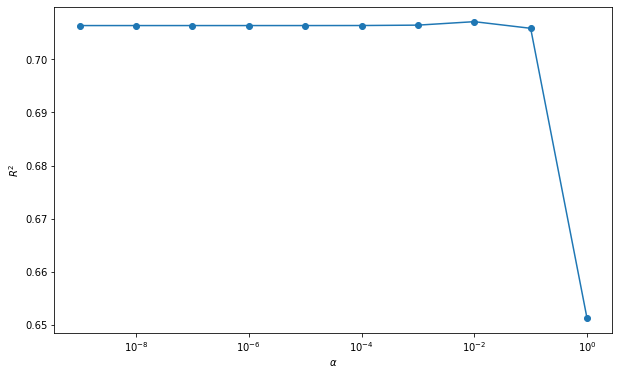

In [26]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [27]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

In [28]:
list(zip(scores,alphas))

[(0.810975466247616, 0.06),
 (0.8224863637940225, 0.07645649914218805),
 (0.8230573042903309, 0.0974266043513233),
 (0.8143160953048916, 0.12414828486688738),
 (0.8044446338622655, 0.1581990539238215),
 (0.7942423307179226, 0.20158909717702692),
 (0.7837829963261634, 0.2568799439231636),
 (0.7762405981594628, 0.3273356868701111),
 (0.77008630147054, 0.4171156777065363),
 (0.769654589109278, 0.5315200742460495),
 (0.7629213902351792, 0.6773027350108134),
 (0.746362920338825, 0.8630699329725978),
 (0.7222912862089705, 1.0997884264994613),
 (0.695253921882193, 1.4014328814540729),
 (0.6715160557453472, 1.7858108649787907),
 (0.6324054431232764, 2.27561411443935),
 (0.580589840077772, 2.8997581431430515),
 (0.5046557947726653, 3.6950892663961565),
 (0.41425023203661404, 4.708559822108766),
 (0.3800935078061405, 6.0)]

If you store the results in a list called `scores`, the following will work:

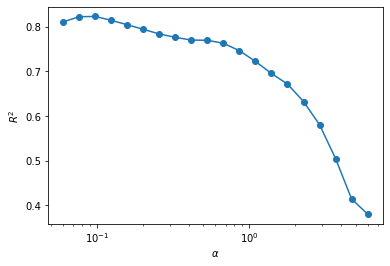

In [29]:
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

In [30]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("scaler", s),
                    ("lasso_regression", Lasso(alpha=0.03,max_iter=100000))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.8797489043756823

In [31]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.38927286,  4.10058254,
        0.        ,  0.        ,  0.        ,  0.        ,  0.30222451,
        0.27782044, -0.        ,  2.10268926, -0.74304651, -0.        ,
       -0.        , -0.51398501, -0.        , -0.        , -0.        ,
       -0.30228132, -0.        ,  0.45727728, -0.42088001, -0.00903069,
        0.        ,  0.21067033, -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.41919627,  0.54776641,
       -0.        ,  0.        , -0.        ,  0.62069609, -0.91326442,
        0.        ,  1.29922576,  0.        ,  0.93495083, -1.9673102 ,
        0.        , -1.77773929, -0.        ,  0.        ,  0.23242486,
       -1.216531  , -0.        ,  0.        ,  1.59180787,  0.        ,
       -0.        , -1.6264956 , -0.        , -0.54802224, -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  7.75

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

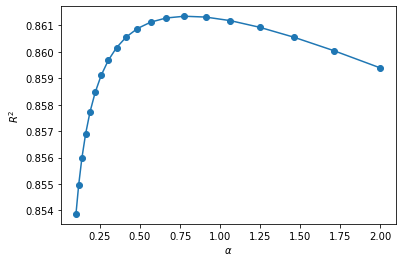

In [32]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(0.1, 2, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000) #Initiating ridge regression

    estimator = Pipeline([
        ("polynomial_features", pf),
        ("scaler", s),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores,'-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

Also, CV is either  used to ensure that the model is not overfitting or to find the suitable level of complexity for ridge or lasso reg

### Exercise:

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


In [33]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2, include_bias = False)),
                    ("scaler", s),
                    ("lasso_regression", Lasso(alpha=0.01))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

/Users/salahkaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 838.7320342368625, tolerance: 4.2716295415019765
  model = cd_fast.enet_coordinate_descent(


0.9047578542960124

In [34]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=X.columns),
                 best_estimator.named_steps["lasso_regression"].coef_))
# col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [35]:
df_importances.sort_values(by=1)

,0,1
72,RM TAX,-7.484883
63,NOX RAD,-5.324131
71,RM RAD,-4.516639
93,RAD LSTAT,-4.455994
48,INDUS LSTAT,-4.416767
...,...,...
3,CHAS,4.057486
103,LSTAT^2,5.467342
95,TAX PTRATIO,7.142666
68,RM^2,8.325413


## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [36]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3], # Two under scores (__) are used to specify the hyperparameters
    'ridge_regression__alpha': np.geomspace(4, 20, 30) #30 values here, 3 in the polynomial, implies 90 different output
}

grid = GridSearchCV(estimator, params, cv=kf)

In [37]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [38]:
grid.best_score_, grid.best_params_

(0.8546333782070418,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 4.0})

In [39]:
y_predict = grid.predict(X)

In [40]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.8964707714558118

In [41]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
pd.DataFrame(grid.best_estimator_.named_steps['ridge_regression'].coef_)

,0
0,0.000000
1,0.247147
2,-1.183778
3,1.117001
4,1.022689
...,...
100,0.311177
101,0.269571
102,-0.664708
103,-1.414440


In [42]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007296,0.003663,0.002687,0.000696,1,4.0,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672111,0.748235,0.701801,0.707382,0.031327,90
1,0.004097,0.000169,0.001798,0.000049,1,4.228267,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672103,0.748207,0.701986,0.707432,0.031307,89
2,0.003827,0.000030,0.001677,0.000003,1,4.46956,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672093,0.748175,0.702178,0.707482,0.031286,88
3,0.003732,0.000010,0.001660,0.000006,1,4.724624,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672081,0.748141,0.702375,0.707533,0.031265,87
4,0.003890,0.000070,0.001692,0.000030,1,4.994243,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672067,0.748104,0.702579,0.707583,0.031243,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.011772,0.000314,0.003281,0.000165,3,16.018444,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827782,0.867759,0.859693,0.851745,0.017261,23
86,0.012056,0.000212,0.003160,0.000151,3,16.932565,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827717,0.867351,0.859455,0.851508,0.017129,25
87,0.011877,0.000267,0.003443,0.000462,3,17.898852,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827628,0.866926,0.859179,0.851244,0.016996,27
88,0.011982,0.000288,0.003461,0.000224,3,18.920281,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827515,0.866483,0.858866,0.850955,0.016863,30


## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage, i.e., Data leakage is when information from outside the training dataset is used to create the model). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.

---
### Machine Learning Foundation (C) 2020 IBM Corporation